# List of libraries:

In [1]:
import pandas as pd
import numpy as np
import subprocess
from io import StringIO
from linearmodels.panel import PanelOLS
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns

## DATA: ICT usage in enterprises

In [2]:
path_file = "../data/SDMXE_2017-2024 v250409.mdb"
tables = subprocess.check_output(["mdb-tables", "-1", path_file]).decode().splitlines()

# Table - DataWithAggregates
table_name = tables[4]
csv_output = subprocess.check_output(["mdb-export", path_file, table_name]).decode()

# Convert csv to DataFrame
df = pd.read_csv(StringIO(csv_output))


/var/folders/jd/z2fjh1_11qq8pyp05ldmsvz00000gn/T/ipykernel_57948/249913561.py:9: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(csv_output))


In [3]:
df.head(10)

,IdYear,IdCountry,IdIndicator,IdEntSize,IdActivity,IdRegion,IdCustBrkdwn,IdUnit,Value,Flags,IdNote
0,17,2,5,2574,2584,2631,2632,11,0.451982,NaN,0
1,17,2,5,2574,2585,2631,2632,11,0.526906,NaN,0
2,17,2,5,2574,2607,2631,2632,11,0.570223,NaN,0
3,17,2,5,2575,2584,2631,2632,11,0.391236,NaN,0
4,17,2,5,2575,2585,2631,2632,11,0.507099,NaN,0
5,17,2,5,2575,2607,2631,2632,11,0.563096,NaN,0
6,17,2,5,2577,2584,2631,2632,11,0.509925,NaN,0
7,17,2,5,2577,2585,2631,2632,11,0.551007,NaN,0
8,17,2,5,2577,2607,2631,2632,11,0.580228,NaN,0
9,17,2,5,2578,2580,2631,2632,11,0.330759,NaN,0


In [4]:
print( "There is", len(df), "rows in this dataset")

There is 12892259 rows in this dataset


In [5]:
# Table - Countries
table_name = tables[2]
csv_output = subprocess.check_output(["mdb-export", path_file, table_name]).decode()
df_country = pd.read_csv(StringIO(csv_output))
df_country.head()

,IdCountry,ExpCountry,ExpCountryCaption
0,2,AT,Austria
1,3,BE,Belgium
2,4,BG,Bulgaria
3,5,CY,Cyprus
4,6,CZ,Czechia


In [6]:
# We only need to keep data from countries, so drop all aggregated data:

# 32       EU15          European Union - 15 countries (1995-2004)
# 33         EA          Euro area (EA11-1999, EA12-2001, EA13-..)
# 35       EU25          European Union - 25 countries (2004-2006)
# 37  EU27_2007          European Union - 27 countries (2007-2013)
# 53       EU28          European Union - 28 countries (2013-2020)
# 45  EU27_2020          European Union - 27 countries (from 2020)

country_id = [32,33,35,37,53,45]
df_filtered = df[~df['IdCountry'].isin(country_id)]

In [7]:
# Table - Indicators
table_name = tables[8]
csv_output = subprocess.check_output(["mdb-export", path_file, table_name]).decode()
df_indicators = pd.read_csv(StringIO(csv_output))
df_indicators.head()

,IdIndicator,ExpIndicator,IdIndicatorGroup,ExpIndicatorCaption
0,4,P_CUSE,NaN,Persons employed using computers
1,5,P_IUSE,189.0,Persons employed have access to the internet f...
2,9,p_intra,NaN,Persons employed by enterprises which use inte...
3,12,p_extra,NaN,Persons employed by enterprises which use Extr...
4,15,p_iacc,NaN,Persons employed by enterprises which have acc...


In [8]:

# Filter indicators, digital intensity index + use any AI technology:

# IdIndicator  ExpIndicator  IdIndicatorGroup  ExpIndicatorCaption

#3160  E_DI3_HI_AI_TANY    111.0  Enterprises with high digital intensity index, which use any artificial intelligence technology
#3165  E_DI3_LO_AI_TANY    111.0  Enterprises with low digital intensity index, which use any artificial intelligence technology
#3170  E_DI3_VHI_AI_TANY   111.0  Enterprises with very high digital intensity index, which use any artificial intelligence technology
#3175  E_DI3_VLO_AI_TANY   111.0  Enterprises with very low digital intensity index, which use any artificial intelligence technology
#3375  E_DI4_HI_AI_TANY    111.0  Enterprises with high digital intensity index (Version 4), which use any artificial intelligence technology
#3383  E_DI4_LO_AI_TANY    111.0  Enterprises with low digital intensity index (Version 4), which use any artificial intelligence technology
#3391  E_DI4_VHI_AI_TANY   111.0  Enterprises with very high digital intensity index (Version 4), which use any artificial intelligence technology
#3399  E_DI4_VLO_AI_TANY   111.0  Enterprises with very low digital intensity index (Version 4), which use any artificial intelligence technology

df_ia = df_indicators[df_indicators['ExpIndicatorCaption'].str.contains('use any Artificial Int', case=False, na=False)]
df_ia['IdIndicator'].unique()

array([3160, 3165, 3170, 3175, 3375, 3383, 3391, 3399])

In [9]:
Any_AI_Tech=[3160, 3165, 3170, 3175, 3375, 3383, 3391, 3399]

df_filtered = df_filtered[df_filtered['IdIndicator'].isin(Any_AI_Tech)]
df_filtered['IdIndicator'].unique()
df_filtered.head()

,IdYear,IdCountry,IdIndicator,IdEntSize,IdActivity,IdRegion,IdCustBrkdwn,IdUnit,Value,Flags,IdNote
9168659,23,2,3160,2574,2584,2631,2632,16,0.034078,NaN,0
9168660,23,2,3160,2574,2585,2631,2632,16,0.045737,NaN,0
9168661,23,2,3160,2574,2607,2631,2632,16,0.051049,NaN,0
9168662,23,2,3160,2575,2584,2631,2632,16,0.026402,NaN,0
9168663,23,2,3160,2575,2585,2631,2632,16,0.041389,NaN,0


In [10]:
# Table - Activities
table_name = tables[0]
csv_output = subprocess.check_output(["mdb-export", path_file, table_name]).decode()
df_Activity = pd.read_csv(StringIO(csv_output))
df_Activity['IdActivity'].unique()
df_Activity.head()

,IdActivity,ExpActivity,IdActivityGroup,ExpActivityCaption
0,2580,C10-C12,90.0,Manufacture of food products; beverages and to...
1,2581,C10-C18,91.0,"Manufacture of products based on: food, bevera..."
2,2582,C,91.0,Manufacturing
3,2583,C-E,91.0,"Manufacturing, electricity, gas, steam and air..."
4,2584,C-F,89.0,"Manufacturing, electricity, gas, steam and air..."


In [11]:
# Table - Units
table_name = tables[14]
csv_output = subprocess.check_output(["mdb-export", path_file, table_name]).decode()
df_Units = pd.read_csv(StringIO(csv_output))
df_Units.head()

,IdUnit,ExpUnit,ExpUnitCaption
0,1,PC_ENT_CUSE,Percentage of the enterprises which use a comp...
1,2,PC_EMP_CUSE,Percentage of persons employed using a computer
2,3,PC_ENT_IACC,Percentage of the enterprises with internet ac...
3,11,PC_EMP,Percentage of total employment
4,14,MIO_EUR,Million euro


In [12]:
# Drop columns, perform an inner join (merge), and rename some columns/countries:
df_filtered = df_filtered.merge(df_country, on="IdCountry",how='inner').drop(columns=['IdCustBrkdwn','IdNote','Flags','IdCountry','IdUnit','IdRegion'])
df_filtered = df_filtered.merge(df_Activity, on="IdActivity",how='inner').drop(columns=['IdActivityGroup','ExpActivityCaption','IdActivity'])
df_filtered = df_filtered.rename(columns={'ExpCountryCaption':'Country', 'ExpCountry':'IdCountry'}).replace('Bosnia and Herzegovina',value='Bosnia')
df_filtered = df_filtered.dropna(subset=['Value'])

In [13]:
df_filtered.head()

,IdYear,IdIndicator,IdEntSize,Value,IdCountry,Country,ExpActivity
0,23,3160,2574,0.034078,AT,Austria,C-F
1,23,3160,2574,0.045737,AT,Austria,C10-S951_X_K
2,23,3160,2574,0.051049,AT,Austria,G45-S951_X_K
3,23,3160,2575,0.026402,AT,Austria,C-F
4,23,3160,2575,0.041389,AT,Austria,C10-S951_X_K


In [14]:
# Dataset original (enterprise)
df_filtered = df_filtered.rename(columns={'ExpActivity':'NACE'})

In [15]:
df_filtered #dataset original IA adoption - 13649 rows

,IdYear,IdIndicator,IdEntSize,Value,IdCountry,Country,NACE
0,23,3160,2574,0.034078,AT,Austria,C-F
1,23,3160,2574,0.045737,AT,Austria,C10-S951_X_K
2,23,3160,2574,0.051049,AT,Austria,G45-S951_X_K
3,23,3160,2575,0.026402,AT,Austria,C-F
4,23,3160,2575,0.041389,AT,Austria,C10-S951_X_K
...,...,...,...,...,...,...,...
15990,24,3399,2578,0.000000,BA,Bosnia,S951
15991,24,3399,2578,0.000000,BA,Bosnia,L_M
15992,24,3399,2579,0.000000,BA,Bosnia,C-F
15993,24,3399,2579,0.000000,BA,Bosnia,C10-S951_X_K


In [16]:
# Group by economic activity at level 1 (A–U):
data_sector = df_filtered.copy()
data_sector['NACE'] = data_sector['NACE'].replace({
    'C10-C12': 'C',
    'C10-C18': 'C',
    'C16-C18': 'C',
    'C19-C23': 'C',
    'C20': 'C',
    'C21': 'C',
    'C22_C23': 'C',
    'C24_C25': 'C',
    'C26': 'C',
    'C26-C33': 'C',
    'C27': 'C',
    'C27_C28': 'C',
    'C28': 'C',
    'C29_C30': 'C',
    'C31-C33': 'C',
    'C13-C15': 'C', 
    'C19':'C'  
})
data_sector['NACE'] = data_sector['NACE'].replace({'D35': 'D'})
data_sector['NACE'] = data_sector['NACE'].replace({'G45': 'G','G46': 'G','G47': 'G'})
data_sector['NACE'] = data_sector['NACE'].replace({'I55': 'I',})
data_sector['NACE'] = data_sector['NACE'].replace({'J58-J60': 'J','J62_J63': 'J','J61': 'J'})
data_sector['NACE'] = data_sector['NACE'].replace({'L68': 'L'})
data_sector['NACE'] = data_sector['NACE'].replace({'M69-M71': 'M','M72': 'M','M73-M75': 'M'})
data_sector['NACE'] = data_sector['NACE'].replace({'N77-N82_X_N79': 'N','N79': 'N'})
data_sector['NACE'] = data_sector['NACE'].replace({'S951': 'S'})

In [17]:
# Remove different economic activities at level 1 (indeterminable classification):"
categorias_a_eliminar = ['L_M', 'C-F', 'C10-S951_X_K', 'G45-S951_X_K','C-E','D_E','ICT']
data_sector = data_sector[~data_sector['NACE'].isin(categorias_a_eliminar)]

In [18]:
data_sector['NACE'].unique()

array(['C', 'D', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'E', 'S'],
      dtype=object)

In [19]:
# Look for duplicates
cols_clave = ['IdYear','IdIndicator', 'IdEntSize', 'Value', 'Country', 'NACE']
duplicados = data_sector[data_sector.duplicated(subset=cols_clave, keep=False)]
duplicados_exactos = data_sector[data_sector.duplicated(keep=False)]
len(duplicados_exactos)==0 #there is duplicates

False

In [20]:
# Delete duplicates
data_sector = data_sector.drop_duplicates(subset=cols_clave)
data_IA = data_sector.copy()
data_IA #7388 obs

,IdYear,IdIndicator,IdEntSize,Value,IdCountry,Country,NACE
9,23,3160,2578,0.037189,AT,Austria,C
10,23,3160,2578,0.042209,AT,Austria,C
11,23,3160,2578,0.061024,AT,Austria,C
16,23,3160,2578,0.053235,AT,Austria,C
18,23,3160,2578,0.062569,AT,Austria,C
...,...,...,...,...,...,...,...
15978,24,3399,2578,0.000000,BA,Bosnia,J
15982,24,3399,2578,0.000000,BA,Bosnia,L
15983,24,3399,2578,0.000000,BA,Bosnia,M
15987,24,3399,2578,0.000000,BA,Bosnia,N


In [21]:
# Finally group by economic activity:
data_sector = data_sector.groupby(['Country','IdYear','NACE'])['Value'].mean().reset_index()
data_sector[data_sector['Country']=='Spain']
data_sector #dataset aggregated by NACE
#687 obs


,Country,IdYear,NACE,Value
0,Austria,23,C,0.055203
1,Austria,23,D,0.126754
2,Austria,23,E,0.014525
3,Austria,23,F,0.010688
4,Austria,23,G,0.030139
...,...,...,...,...
682,Sweden,24,J,0.139043
683,Sweden,24,L,0.038415
684,Sweden,24,M,0.117257
685,Sweden,24,N,0.049761


## DATA: Employment data

In [22]:
path = "../data/lfsa_eisn2.xlsx"

There are a lot of sheets, so we need to automate this task and retrive the data for each NACE and ISCO id.

In [23]:
# Mapping different sectors and occupations:

NACE_Id = {"Agriculture, forestry and fishing":"A",
"Mining and quarrying":"B",
"Manufacturing":"C",
"Electricity, gas, steam and air conditioning supply":"D",
"Water supply; sewerage, waste management and remediation activities":"E",
"Construction":"F",
"Wholesale and retail trade; repair of motor vehicles and motorcycles":"G",
"Transportation and storage":"H",
"Accommodation and food service activities":"I",
"Information and communication":"J",
"Financial and insurance activities":"K",
"Real estate activities":"L",
"Professional, scientific and technical activities":"M",
"Administrative and support service activities":"N",
"Public administration and defence; compulsory social security":"O",
"Education":"P",
"Human health and social work activities":"Q",
"Arts, entertainment and recreation":"R",
"Other service activities":"S",
"Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use":"T",
"Activities of extraterritorial organisations and bodies":"U"}

ISCO_Id = {"Managers":"OC1",
"Professionals":"OC2",
"Technicians": "OC3",
"Clerical support workers":"OC4",
"Service and sales workers":"OC5",
"Skilled agricultural, forestry and fishery workers":"OC6",
"Craft and related trades workers":"OC7",
"Plant and machine operators and assemblers":"OC8",
"Elementary occupations":"OC9",
"Armed forces occupations":"OC0"}

In [24]:
# Iterate to extract values from sheets:

dataset = None
sheet_num = 2

while sheet_num < 212:
    df = pd.read_excel(path, sheet_num, header=None)
    sheet_num += 1
    print(f"Hoja {sheet_num-1}")

    # — FIND ISCO —
    for key, value in ISCO_Id.items():
        if df[2].astype(str).str.contains(key, na=False, case=True, regex=False).any():
            df['ISCO_08'] = value
            break

    # — FIND NACE —
    for key, value in NACE_Id.items():
        if df[2].astype(str).str.contains(key, na=False, case=False, regex=False).any():
            df['NACE'] = value
            break

    # — RENAME AND CLEAN COLUMN —
    df.rename(columns={0: "Country", 1: "23", 3: "24"}, inplace=True)
    df.drop(columns=[2, 4], errors='ignore', inplace=True)

    # — FILTER ROWS OF INTEREST —
    df = df.iloc[13:49].reset_index(drop=True)

    # — CONCAT TO DATASET —
    if dataset is None:
        dataset = df.copy()
    else:
        dataset = pd.concat([dataset, df], ignore_index=True)

/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 2


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 3


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 4
Hoja 5


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 6


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 7


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 8


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 9


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 10


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 11


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 12


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 13


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 14
Hoja 15


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 16


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 17


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 18


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 19


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 20


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 21


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 22


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 23


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 24
Hoja 25


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 26


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 27


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 28


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 29


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 30


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 31


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 32


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 33


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 34
Hoja 35


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 36


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 37


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 38


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 39


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 40


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 41


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 42


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 43
Hoja 44


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 45


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 46


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 47


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 48


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 49


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 50


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 51


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 52
Hoja 53


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 54


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 55


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 56


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 57


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 58


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 59


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 60


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 61
Hoja 62


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 63


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 64


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 65


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 66


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 67


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 68


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 69


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 70


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 71
Hoja 72


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 73


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 74


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 75


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 76


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 77


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 78


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 79


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 80


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 81
Hoja 82


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 83


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 84


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 85


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 86


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 87


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 88


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 89


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 90
Hoja 91


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 92


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 93


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 94


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 95


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 96


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 97


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 98


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 99


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 100
Hoja 101


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 102


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 103


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 104


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 105


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 106


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 107


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 108


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 109
Hoja 110


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 111


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 112


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 113


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 114


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 115


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 116


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 117


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 118


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 119
Hoja 120


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 121


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 122


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 123


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 124


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 125


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 126


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 127


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 128
Hoja 129


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 130


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 131


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 132


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 133


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 134


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 135


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 136


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 137


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 138
Hoja 139


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 140


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 141


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 142


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 143


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 144


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 145


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 146


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 147


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 148
Hoja 149


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 150


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 151


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 152


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 153


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 154


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 155


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 156


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 157
Hoja 158


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 159


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 160


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 161


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 162


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 163


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 164


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 165


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 166


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 167
Hoja 168


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 169


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 170


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 171


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 172


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 173


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 174


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 175


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 176
Hoja 177


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 178


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 179


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 180


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 181


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 182


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 183


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 184


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 185


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 186
Hoja 187


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 188


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 189


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 190


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 191


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 192


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 193


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 194
Hoja 195


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 196


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 197


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 198


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 199


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 200


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 201


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 202


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 203
Hoja 204


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 205
Hoja 206


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 207


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 208


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 209


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 210


/Users/edu/Desktop/Github/Efectos-IA-Empleo/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Hoja 211


In [25]:
# Melt function (create columns IdYear y occ, from columns 23, 24):
id_vars2= ['Country','ISCO_08', 'NACE']
year_cols = ["23","24"] 
data_ISCO = dataset.melt(id_vars=id_vars2,value_vars=year_cols,var_name='IdYear',value_name='occ')
data_ISCO.head()

,Country,ISCO_08,NACE,IdYear,occ
0,Belgium,OC1,A,23,2.7
1,Bulgaria,OC1,A,23,5.1
2,Czechia,OC1,A,23,5.6
3,Denmark,OC1,A,23,:
4,Germany,OC1,A,23,:


In [26]:
# Establecer datos NA a valores cero
data_ISCO.replace(':',0, inplace=True)

/var/folders/jd/z2fjh1_11qq8pyp05ldmsvz00000gn/T/ipykernel_57948/1692706965.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_ISCO.replace(':',0, inplace=True)


In [27]:
# Transformación de datos:
total_sector = data_ISCO.groupby(['Country', 'NACE','IdYear'])['occ'].sum().reset_index()
total_sector = total_sector.rename(columns={'occ': 'occ_sector'})
total_sector.head()

,Country,NACE,IdYear,occ_sector
0,Austria,A,23,133.4
1,Austria,A,24,120.1
2,Austria,B,23,0.0
3,Austria,B,24,0.0
4,Austria,C,23,743.5


In [28]:
data_ISCO = data_ISCO.merge(total_sector, on=['Country', 'NACE','IdYear'], how='left')
data_ISCO['Share_Occupation'] = data_ISCO['occ']/data_ISCO['occ_sector']
data_ISCO.head()

,Country,ISCO_08,NACE,IdYear,occ,occ_sector,Share_Occupation
0,Belgium,OC1,A,23,2.7,49.1,0.054990
1,Bulgaria,OC1,A,23,5.1,163.5,0.031193
2,Czechia,OC1,A,23,5.6,139.1,0.040259
3,Denmark,OC1,A,23,0.0,53.7,0.000000
4,Germany,OC1,A,23,0.0,497.7,0.000000


In [29]:
total_occupation = data_ISCO.groupby(['Country','IdYear'])['occ'].sum().reset_index()
total_occupation = total_occupation.rename(columns={'occ':'occ_total'})

data_ISCO = data_ISCO.merge(total_occupation,on=['Country','IdYear'], how="left")
data_ISCO['Share_Sector'] = data_ISCO['occ_sector']/data_ISCO['occ_total']
data_ISCO.head()

,Country,ISCO_08,NACE,IdYear,occ,occ_sector,Share_Occupation,occ_total,Share_Sector
0,Belgium,OC1,A,23,2.7,49.1,0.054990,4998.5,0.009823
1,Bulgaria,OC1,A,23,5.1,163.5,0.031193,2869.2,0.056985
2,Czechia,OC1,A,23,5.6,139.1,0.040259,5058.4,0.027499
3,Denmark,OC1,A,23,0.0,53.7,0.000000,2900.9,0.018511
4,Germany,OC1,A,23,0.0,497.7,0.000000,42418.7,0.011733


In [30]:
# Limpieza de datos:
data_ISCO =data_ISCO[data_ISCO['Country']!='Montenegro']
data_ISCO =data_ISCO[data_ISCO['Country']!='United Kingdom']
data_ISCO =data_ISCO[data_ISCO['Country']!='North Macedonia']
data_ISCO.replace("Bosnia and Herzegovina","Bosnia",inplace=True)
data_ISCO.drop(['occ','occ_sector','occ_total'], axis=1, inplace=True)
data_ISCO = data_ISCO.dropna()

In [31]:
# Comprovamos datos correctos:
data_ISCO['Country'].unique()

array(['Belgium', 'Bulgaria', 'Czechia', 'Denmark', 'Germany', 'Estonia',
       'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
       'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
       'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
       'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'Iceland', 'Norway',
       'Switzerland', 'Bosnia', 'Serbia', 'Türkiye'], dtype=object)

In [32]:
data_ISCO['ISCO_08'].unique()

array(['OC1', 'OC2', 'OC3', 'OC4', 'OC5', 'OC6', 'OC7', 'OC8', 'OC9',
       'OC0'], dtype=object)

In [33]:
data_ISCO['NACE'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'], dtype=object)

In [34]:
data_ISCO.head()

,Country,ISCO_08,NACE,IdYear,Share_Occupation,Share_Sector
0,Belgium,OC1,A,23,0.054990,0.009823
1,Bulgaria,OC1,A,23,0.031193,0.056985
2,Czechia,OC1,A,23,0.040259,0.027499
3,Denmark,OC1,A,23,0.000000,0.018511
4,Germany,OC1,A,23,0.000000,0.011733


In [35]:
# Agrupamos por Sector:
data_NACE = data_ISCO.groupby(['Country','IdYear','NACE'])['Share_Sector'].mean().reset_index()

# Corregimos formato:
data_NACE['IdYear'] = data_NACE['IdYear'].astype(int)
data_ISCO['IdYear'] = data_ISCO['IdYear'].astype(int)

# Comprovamos datos correctos:
data_NACE[data_NACE['Country']=='Germany']['Share_Sector'].sum() #ejemplo

np.float64(2.0)

In [36]:
data_NACE #datos agrupados por sectores

,Country,IdYear,NACE,Share_Sector
0,Austria,23,A,0.030219
1,Austria,23,C,0.168422
2,Austria,23,D,0.006026
3,Austria,23,E,0.004145
4,Austria,23,F,0.079080
...,...,...,...,...
1264,Türkiye,24,Q,0.063372
1265,Türkiye,24,R,0.005843
1266,Türkiye,24,S,0.026186
1267,Türkiye,24,T,0.004339


In [37]:
data_ISCO #1269*10 ocupaciones = 12690 obs

,Country,ISCO_08,NACE,IdYear,Share_Occupation,Share_Sector
0,Belgium,OC1,A,23,0.054990,0.009823
1,Bulgaria,OC1,A,23,0.031193,0.056985
2,Czechia,OC1,A,23,0.040259,0.027499
3,Denmark,OC1,A,23,0.000000,0.018511
4,Germany,OC1,A,23,0.000000,0.011733
...,...,...,...,...,...,...
15096,Cyprus,OC0,U,24,0.000000,0.001473
15099,Luxembourg,OC0,U,24,0.000000,0.095390
15113,Switzerland,OC0,U,24,0.000000,0.000845
15115,Bosnia,OC0,U,24,0.000000,0.001985


## DATA: Macro data + Merging

In [38]:
file_path = "../data/macro data.xlsx"
df_agreggdata = pd.read_excel(file_path, sheet_name=0)
df_agreggdata.head()

,Country,IdYear,GDPCap,Educ_Rate,RD_exp,Unempl_rate
0,Belgium,23,44120.0,0.503583,0.0246,0.055
1,Bulgaria,23,10970.0,0.340256,0.0051,0.043
2,Czechia,23,21660.0,0.270515,0.0119,0.026
3,Denmark,23,58640.0,0.408531,0.0183,0.051
4,Germany,23,42780.0,0.331712,0.0212,0.031


#                          -- MODELO 1 - SECTORIAL --

In [39]:
data_sector

,Country,IdYear,NACE,Value
0,Austria,23,C,0.055203
1,Austria,23,D,0.126754
2,Austria,23,E,0.014525
3,Austria,23,F,0.010688
4,Austria,23,G,0.030139
...,...,...,...,...
682,Sweden,24,J,0.139043
683,Sweden,24,L,0.038415
684,Sweden,24,M,0.117257
685,Sweden,24,N,0.049761


In [40]:
# Combinamos con datos macroeconomicos:
data_sector = data_sector.merge(df_agreggdata, on=["Country", "IdYear"], how="left")
data_sector.drop('RD_exp',axis=1,inplace=True)
data_sector = data_sector.dropna()

# Creamos copia:
data_occupation = data_sector.copy()

In [41]:
# Combinamos con datos de empleo:
data_sector = data_sector.merge(data_NACE, on=["Country", "IdYear","NACE"], how="left")
data_sector = data_sector.dropna()
data_sector #644

,Country,IdYear,NACE,Value,GDPCap,Educ_Rate,Unempl_rate,Share_Sector
0,Austria,23,C,0.055203,45510.0,0.387912,0.051,0.168422
1,Austria,23,D,0.126754,45510.0,0.387912,0.051,0.006026
2,Austria,23,E,0.014525,45510.0,0.387912,0.051,0.004145
3,Austria,23,F,0.010688,45510.0,0.387912,0.051,0.079080
4,Austria,23,G,0.030139,45510.0,0.387912,0.051,0.142621
...,...,...,...,...,...,...,...,...
648,Sweden,24,J,0.139043,48810.0,0.489769,0.084,0.057350
649,Sweden,24,L,0.038415,48810.0,0.489769,0.084,0.016682
650,Sweden,24,M,0.117257,48810.0,0.489769,0.084,0.108474
651,Sweden,24,N,0.049761,48810.0,0.489769,0.084,0.046280


##                          -- MODELO 2 - OCUPACIONAL --

In [42]:
data_occupation

,Country,IdYear,NACE,Value,GDPCap,Educ_Rate,Unempl_rate
0,Austria,23,C,0.055203,45510.0,0.387912,0.051
1,Austria,23,D,0.126754,45510.0,0.387912,0.051
2,Austria,23,E,0.014525,45510.0,0.387912,0.051
3,Austria,23,F,0.010688,45510.0,0.387912,0.051
4,Austria,23,G,0.030139,45510.0,0.387912,0.051
...,...,...,...,...,...,...,...
682,Sweden,24,J,0.139043,48810.0,0.489769,0.084
683,Sweden,24,L,0.038415,48810.0,0.489769,0.084
684,Sweden,24,M,0.117257,48810.0,0.489769,0.084
685,Sweden,24,N,0.049761,48810.0,0.489769,0.084


In [43]:
# Combinamos con datos de empleo
data_occupation = data_occupation.merge(data_ISCO, on=["Country", "IdYear",'NACE'], how="left")
data_occupation = data_occupation.dropna()
data_occupation #6440

,Country,IdYear,NACE,Value,GDPCap,Educ_Rate,Unempl_rate,ISCO_08,Share_Occupation,Share_Sector
0,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC1,0.069536,0.168422
1,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC2,0.113248,0.168422
2,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC3,0.196638,0.168422
3,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC4,0.084062,0.168422
4,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC5,0.053127,0.168422
...,...,...,...,...,...,...,...,...,...,...
6444,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC6,0.044741,0.024485
6445,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC7,0.043171,0.024485
6446,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC8,0.025903,0.024485
6447,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC9,0.054945,0.024485


##                                                                       --- REGRESIONES ---
# MODELO 1 - SECTORIAL

In [44]:
data_sector

,Country,IdYear,NACE,Value,GDPCap,Educ_Rate,Unempl_rate,Share_Sector
0,Austria,23,C,0.055203,45510.0,0.387912,0.051,0.168422
1,Austria,23,D,0.126754,45510.0,0.387912,0.051,0.006026
2,Austria,23,E,0.014525,45510.0,0.387912,0.051,0.004145
3,Austria,23,F,0.010688,45510.0,0.387912,0.051,0.079080
4,Austria,23,G,0.030139,45510.0,0.387912,0.051,0.142621
...,...,...,...,...,...,...,...,...
648,Sweden,24,J,0.139043,48810.0,0.489769,0.084,0.057350
649,Sweden,24,L,0.038415,48810.0,0.489769,0.084,0.016682
650,Sweden,24,M,0.117257,48810.0,0.489769,0.084,0.108474
651,Sweden,24,N,0.049761,48810.0,0.489769,0.084,0.046280


In [45]:
# Algunas correcciones:
data_sector.rename(columns={'Value':"IA_Adoption",'Unempl_rate':'Unemp_Rate'},inplace=True)

# Establecer 'M' como la categoría base:
categorias = list(data_sector['NACE'].unique())
categorias.remove('M')
nueva_orden = ['M'] + sorted(categorias)  # Poner 'M' al inicio, luego el resto ordenado
data_sector['NACE'] = pd.Categorical(data_sector['NACE'], categories=nueva_orden, ordered=True)
data_sector['NACE']

0      C
1      D
2      E
3      F
4      G
      ..
648    J
649    L
650    M
651    N
652    S
Name: NACE, Length: 644, dtype: category
Categories (12, object): ['M' < 'C' < 'D' < 'E' ... 'J' < 'L' < 'N' < 'S']

## PANEL SECTOR

In [46]:
# Asegúrate de que tanto 'Country' como 'IdYear' estén en el índice
data_panel_sector = data_sector.set_index(['Country', 'IdYear'])

# Estimación con efectos fijos por entidad (país) y tiempo (año)
modelo_panel = PanelOLS.from_formula(
    'Share_Sector ~ IA_Adoption + GDPCap + Educ_Rate + Unemp_Rate + C(NACE)*IA_Adoption + EntityEffects + TimeEffects',
    data=data_panel_sector
)
results_sector = modelo_panel.fit(cov_type='clustered', cluster_entity=True)
print(results_sector.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           Share_Sector   R-squared:                        0.8412
Estimator:                   PanelOLS   R-squared (Between):              0.3228
No. Observations:                 644   R-squared (Within):               0.8412
Date:                Thu, Sep 25 2025   R-squared (Overall):              0.8347
Time:                        00:04:20   Log-likelihood                    1620.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      119.79
Entities:                          29   P-value                           0.0000
Avg Obs:                       22.207   Distribution:                  F(26,588)
Min Obs:                       16.000                                           
Max Obs:                       24.000   F-statistic (robust):          2.338e+05
                            

## EFECTOS DIRECTOS SECTORIAL

In [47]:
sectores = ['C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'N', 'S']
resultados = {}

for sector in sectores:
    coef_interaccion = f'C(NACE)[T.{sector}]:IA_Adoption'
    
    if ('IA_Adoption' not in results_sector.params.index):
        print("No existe coef_base")
    if (coef_interaccion not in results_sector.params.index):
        print(f"No existe coef_interaccion para sector {sector}")
        continue
    coef_base = results_sector.params['IA_Adoption']
    coef_sector = results_sector.params[coef_interaccion]
    print(f"Coef_base: {coef_base}, Coef_sector: {coef_sector}")  # Debug
    
    efecto_total = coef_base + coef_sector

    cov = results_sector.cov
    se_total = np.sqrt(
        cov.loc['IA_Adoption', 'IA_Adoption'] +
        cov.loc[coef_interaccion, coef_interaccion] +
        2 * cov.loc['IA_Adoption', coef_interaccion]
    )
    t_stat = efecto_total / se_total
    p_value = 2 * (1 - norm.cdf(np.abs(t_stat)))
    resultados[sector] = {
        'Efecto Total': efecto_total,
        'Error estándar': se_total,
        't': t_stat,
        'p-value': p_value
    }

df_resultados = pd.DataFrame(resultados).T
print(df_resultados)

Coef_base: 0.2575628761689497, Coef_sector: -0.7549758612303622
Coef_base: 0.2575628761689497, Coef_sector: -0.26820594292923994
Coef_base: 0.2575628761689497, Coef_sector: -0.2483994955730136
Coef_base: 0.2575628761689497, Coef_sector: -0.646712373867692
Coef_base: 0.2575628761689497, Coef_sector: -0.7006251032212949
Coef_base: 0.2575628761689497, Coef_sector: -0.5521112072074279
Coef_base: 0.2575628761689497, Coef_sector: -0.09001688193827068
Coef_base: 0.2575628761689497, Coef_sector: -0.16006205143695038
Coef_base: 0.2575628761689497, Coef_sector: -0.11490487707399515
Coef_base: 0.2575628761689497, Coef_sector: -0.06869019358174847
Coef_base: 0.2575628761689497, Coef_sector: -0.18623041868413906
   Efecto Total  Error estándar         t   p-value
C     -0.497413        0.407065 -1.221948  0.221727
D     -0.010643        0.016146 -0.659189  0.509775
E      0.009163        0.065527  0.139841  0.888786
F     -0.389149        0.229912 -1.692601  0.090532
G     -0.443062        0.212104

## MODELO 2 - OCUPACIONAL

In [48]:
data_occupation = data_occupation.dropna()
data_occupation

,Country,IdYear,NACE,Value,GDPCap,Educ_Rate,Unempl_rate,ISCO_08,Share_Occupation,Share_Sector
0,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC1,0.069536,0.168422
1,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC2,0.113248,0.168422
2,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC3,0.196638,0.168422
3,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC4,0.084062,0.168422
4,Austria,23,C,0.055203,45510.0,0.387912,0.051,OC5,0.053127,0.168422
...,...,...,...,...,...,...,...,...,...,...
6444,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC6,0.044741,0.024485
6445,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC7,0.043171,0.024485
6446,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC8,0.025903,0.024485
6447,Sweden,24,S,0.000000,48810.0,0.489769,0.084,OC9,0.054945,0.024485


In [49]:
# Establecer la categoría base
categorias = list(data_occupation['ISCO_08'].unique())
categorias.remove('OC2')
nueva_orden = ['OC2'] + sorted(categorias)
data_occupation['ISCO_08'] = pd.Categorical(data_occupation['ISCO_08'], categories=nueva_orden, ordered=True)
data_occupation['ISCO_08']

data_occupation.rename(columns={'Value':"IA_Adoption",'Unempl_rate':'Unemp_Rate'},inplace=True)

##               PANEL OCUPACIONAL

In [50]:
# Asegúrate de que la base YA está agregada a nivel sector-país-año-ocupación
# y de que Country, NACE y IdYear están en columnas.

data_panel_occ = data_occupation.set_index(['Country', 'IdYear'])

# data_panel_occ ya tiene MultiIndex (Country, IdYear) y columna NACE

# 1) Captura los niveles del índice
paises = data_panel_occ.index.get_level_values('Country')
años   = data_panel_occ.index.get_level_values('IdYear')

# 2) Crea el vector de cluster concatenando Country, NACE y IdYear
clusters = paises.astype(str) + '_' + \
           data_panel_occ['NACE'].astype(str) + '_' + \
           años.astype(str)

# 3) Estima el modelo, pasando clusters como cluster_entity

formula = (
    'Share_Occupation ~ IA_Adoption + GDPCap + Educ_Rate + Unemp_Rate + C(NACE) + C(ISCO_08)*IA_Adoption + EntityEffects + TimeEffects'
)
modelo_occ = PanelOLS.from_formula(formula, data=data_panel_occ)

results_occ = modelo_occ.fit(
    cov_type='clustered',
    clusters=clusters
)
print(results_occ.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       Share_Occupation   R-squared:                        0.2661
Estimator:                   PanelOLS   R-squared (Between):          -5.179e+06
No. Observations:                6440   R-squared (Within):               0.2661
Date:                Thu, Sep 25 2025   R-squared (Overall):              0.2661
Time:                        00:04:20   Log-likelihood                    3753.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      70.064
Entities:                          29   P-value                           0.0000
Avg Obs:                       222.07   Distribution:                 F(33,6377)
Min Obs:                       160.00                                           
Max Obs:                       240.00   F-statistic (robust):         -2.326e+18
                            

##        EFECTOS DIRECTOS OCUPACIONAL

In [51]:
# Supongamos que tu resultado de PanelOLS está en la variable results_occ
# y que las categorías ISCO-08 están en la lista siguiente (incluyendo la base 'OC2'):
ocupaciones = ['OC0', 'OC1', 'OC2', 'OC3', 'OC4', 'OC5', 'OC6', 'OC7', 'OC8', 'OC9']

# Extraemos coeficiente base de IA_Adoption y la matriz var-cov
beta_base = results_occ.params['IA_Adoption']
vcov = results_occ.cov

# Prepara lista para guardar resultados
filas = []

for oc in ocupaciones:
    if oc == 'OC2':
        # Para la categoría base, el efecto total es simplemente beta_base
        total = beta_base
        var_total = vcov.loc['IA_Adoption','IA_Adoption']
    else:
        term = f'C(ISCO_08)[T.{oc}]:IA_Adoption'
        beta_int = results_occ.params[term]
        # var(total) = var(base) + var(int) + 2 cov(base,int)
        var_total = (
            vcov.loc['IA_Adoption','IA_Adoption'] +
            vcov.loc[term,term] +
            2 * vcov.loc['IA_Adoption',term]
        )
        total = beta_base + beta_int

    se = np.sqrt(var_total)
    t_stat = total / se
    # gls approx: con muchos grados, usamos normal aprox o t con df large
    p_val = 2 * (1 - stats.norm.cdf(abs(t_stat)))

    filas.append({
        'ISCO': oc,
        'Efecto Total': total,
        'Error estándar': se,
        't': t_stat,
        'p-value': p_val
    })

df_effects_isco = pd.DataFrame(filas).set_index('ISCO')
print(df_effects_isco)

      Efecto Total  Error estándar          t       p-value
ISCO                                                       
OC0      -0.000067        0.000541  -0.124804  9.006790e-01
OC1       0.040317        0.053020   0.760409  4.470099e-01
OC2       3.706992        0.305779  12.123127  0.000000e+00
OC3       0.490175        0.142945   3.429129  6.055207e-04
OC4      -0.099665        0.079349  -1.256034  2.091035e-01
OC5      -1.325858        0.185349  -7.153318  8.471002e-13
OC6       0.000644        0.010626   0.060576  9.516969e-01
OC7      -1.014896        0.188188  -5.392982  6.929785e-08
OC8      -0.932223        0.100642  -9.262771  0.000000e+00
OC9      -0.865419        0.088340  -9.796409  0.000000e+00


##  MODELO 3 - TEORICO:

In [52]:
# 1. Carga el Excel
path = "../data/RTI_ISCO08_major_groups.xlsx"

In [53]:
# Asumimos que la hoja que contiene NRA, NRI, RC, RM, NRM y RTI es la segunda (index 1)
df = pd.read_excel(path, sheet_name=1)
df
df_2 = pd.read_excel(path, sheet_name=0)
df_2 = df_2[['Mean_RTI','ISCO_08']]
df_2

# 2. Agrupa y calcula medias
agg = (
    df
    .groupby(["ISCO_08"], as_index=False)
    .agg({
        "NRA": "mean",
        "NRI": "mean",
        "RC" : "mean",
        "RM" : "mean",
        "NRM":"mean",
        "RTI":"mean"
    })
)

# 3. Formatea el código de grupo OC1…OC9 y las medias a 2 decimales con coma decimal
agg["ISCO_08"] = agg["ISCO_08"].astype(str).apply(lambda x: f"{x}")
for col in ["NRA","NRI","RC","RM","NRM","RTI"]:
    agg[col] = (
        agg[col]
        .round(2)                    # dos decimales
        .astype(str)
        .str.replace(".", ",")       # coma decimal
    )

# 4. Ordena por código para que quede OC1…OC9
agg = agg.sort_values("ISCO_08").reset_index(drop=True)
agg

# 1) Convertir comas a puntos y a float en agg
for col in ['NRA','NRI','RC','RM','NRM','RTI']:
    agg[col] = agg[col].str.replace(',','.').astype(float)

# 2) Hacer merge con data_occupation (10 filas por sector-país-año)
data_occ = data_occupation.merge(agg, on='ISCO_08', how='left')
data_occ = data_occ.merge(df_2,how='left', on="ISCO_08")
data_occ
data_occ = data_occ.dropna()
data_occ
# 3) Agrupar para obtener un solo RTI ponderado por sector-país-año
#    Usamos Share_Occupation como peso, y recuperamos los controles (tomamos el primero)
data_theory = (
    data_occ
    .groupby(['Country','IdYear','NACE'], as_index=False)
    .agg({
        'IA_Adoption':    'first',
        'GDPCap':         'first',
        'Educ_Rate':      'first',
        'Unemp_Rate':     'first',
        'Share_Sector':   'first',
        # Media ponderada:
        'RTI':            lambda x: (x * data_occ.loc[x.index, 'Share_Occupation']).sum(),
        # Si quieres también los componentes:
        'NRA':            lambda x: (x * data_occ.loc[x.index, 'Share_Occupation']).sum(),
        'NRI':            lambda x: (x * data_occ.loc[x.index, 'Share_Occupation']).sum(),
        'RC':             lambda x: (x * data_occ.loc[x.index, 'Share_Occupation']).sum(),
        'RM':             lambda x: (x * data_occ.loc[x.index, 'Share_Occupation']).sum(),
        'NRM':            lambda x: (x * data_occ.loc[x.index, 'Share_Occupation']).sum(),
        'Mean_RTI':       lambda x: (x * data_occ.loc[x.index, 'Share_Occupation']).sum()
    })
)
data_theory #dataset para modelos teoricos

,Country,IdYear,NACE,IA_Adoption,GDPCap,Educ_Rate,Unemp_Rate,Share_Sector,RTI,NRA,NRI,RC,RM,NRM,Mean_RTI
0,Austria,23,C,0.055203,45510.0,0.387912,0.051,0.168422,-0.337260,0.195341,0.155809,0.192028,0.139387,0.316904,-0.389432
1,Austria,23,D,0.126754,45510.0,0.387912,0.051,0.006026,-0.369323,0.303459,0.235639,0.257143,0.060526,0.143233,-0.417631
2,Austria,23,E,0.014525,45510.0,0.387912,0.051,0.004145,-0.146393,0.074754,0.091803,0.248689,0.180000,0.404754,-0.180648
3,Austria,23,F,0.010688,45510.0,0.387912,0.051,0.079080,-0.275242,0.151862,0.112970,0.193807,0.167600,0.373612,-0.354525
4,Austria,23,G,0.030139,45510.0,0.387912,0.051,0.142621,-0.438181,0.148415,0.207513,0.216860,0.062908,0.360133,-0.452825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,Sweden,24,J,0.139043,48810.0,0.489769,0.084,0.057350,-0.770359,0.524219,0.326756,0.111461,0.004725,0.032838,-0.775385
640,Sweden,24,L,0.038415,48810.0,0.489769,0.084,0.016682,-0.482339,0.270472,0.263859,0.242696,0.017753,0.202753,-0.499202
641,Sweden,24,M,0.117257,48810.0,0.489769,0.084,0.108474,-0.640546,0.450916,0.301347,0.163701,0.017954,0.065948,-0.656047
642,Sweden,24,N,0.049761,48810.0,0.489769,0.084,0.046280,-0.412978,0.173904,0.171902,0.203248,0.090648,0.359007,-0.444455


##                               PANEL TEORICO 1

In [54]:
# 1. Prepara el panel con country y year como índice
data_panel_theory = data_theory.set_index(['Country', 'IdYear'])

# 2. Fórmula: IA, RTI y su interacción, más los controles y efectos fijos
formula = (
    'Share_Sector ~ IA_Adoption + Mean_RTI + IA_Adoption:Mean_RTI + GDPCap + Educ_Rate + Unemp_Rate+ EntityEffects + TimeEffects'
)

# 3. Estima con efectos fijos por entidad y tiempo, errores clusterizados
modelo_theory = PanelOLS.from_formula(formula, data=data_panel_theory)
results_theory = modelo_theory.fit(
    cov_type='clustered',
    cluster_entity=True
)

# 4. Muestra resultados
print(results_theory.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           Share_Sector   R-squared:                        0.0240
Estimator:                   PanelOLS   R-squared (Between):             -0.3278
No. Observations:                 644   R-squared (Within):               0.0239
Date:                Thu, Sep 25 2025   R-squared (Overall):             -0.1808
Time:                        00:04:21   Log-likelihood                    1036.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.4904
Entities:                          29   P-value                           0.0218
Avg Obs:                       22.207   Distribution:                   F(6,608)
Min Obs:                       16.000                                           
Max Obs:                       24.000   F-statistic (robust):             5.7286
                            

##                              PANEL TEORICO 2:

In [55]:
# 1. Creamos el panel con Country y IdYear como índice
data_panel = data_theory.set_index(['Country', 'IdYear'])

# 2. Definimos la fórmula del modelo de sub-tareas (omitimos RC como categoría base)
formula_sub = (
    'Share_Sector ~ IA_Adoption '
    '+ IA_Adoption:NRA + IA_Adoption:NRI '
    '+ IA_Adoption:RM  + IA_Adoption:NRM '
    '+ NRA + NRI + RM + NRM '
    '+ GDPCap + Educ_Rate + Unemp_Rate '
    '+ EntityEffects + TimeEffects'
)

# 3. Estimamos con PanelOLS y errores estándar clusterizados por entidad (país)
modelo_sub = PanelOLS.from_formula(formula_sub, data=data_panel)
results_sub = modelo_sub.fit(
    cov_type='clustered',
    cluster_entity=True
)

# 4. Imprimimos el resumen de resultados
print(results_sub.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           Share_Sector   R-squared:                        0.2036
Estimator:                   PanelOLS   R-squared (Between):             -30.672
No. Observations:                 644   R-squared (Within):               0.2008
Date:                Thu, Sep 25 2025   R-squared (Overall):             -17.849
Time:                        00:04:21   Log-likelihood                    1101.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.827
Entities:                          29   P-value                           0.0000
Avg Obs:                       22.207   Distribution:                  F(12,602)
Min Obs:                       16.000                                           
Max Obs:                       24.000   F-statistic (robust):             21.181
                            

## EFECTOS DIRECTOS TEORICO SUB-TAREAS

In [56]:
# Lista de subtareas y la categoría base (RC)
subtareas = ['RC', 'NRA', 'NRI', 'RM', 'NRM']

# Extraemos parámetros y matriz de var-cov
b = results_sub.params
V = results_sub.cov

resultados = {}

# Función helper para cada subtarea
for tarea in subtareas:
    if tarea == 'RC':
        # Efecto puro IA en la categoría omitida (RC=1)
        efecto = b['IA_Adoption']
        var = V.loc['IA_Adoption','IA_Adoption']
    else:
        # Interacción IA × tarea
        inter = f'IA_Adoption:{tarea}'
        coef_int = b.get(inter, 0.0)
        efecto = b['IA_Adoption'] + coef_int

        # var(β1 + β_int) = var(β1) + var(β_int) + 2 cov(β1, β_int)
        var = (
            V.loc['IA_Adoption','IA_Adoption']
            + V.loc[inter, inter]
            + 2 * V.loc['IA_Adoption', inter]
        )

    se = np.sqrt(var)
    t  = efecto / se
    p  = 2 * (1 - norm.cdf(abs(t)))

    resultados[tarea] = {
        'Efecto_total': efecto,
        'SE':            se,
        't':             t,
        'p-value':       p
    }

df_ef = pd.DataFrame(resultados).T
print(df_ef.round(4))

     Efecto_total      SE       t  p-value
RC        -1.5088  0.9563 -1.5777   0.1146
NRA       -2.7520  2.0720 -1.3282   0.1841
NRI        4.7913  3.5896  1.3348   0.1820
RM         6.1133  2.8184  2.1691   0.0301
NRM       -1.2922  0.8511 -1.5183   0.1289


##                                                                      --- PRUEBA DE ROBUSTEZ ---


# --MODELO 1 - SECTORIAL --

In [57]:
# - VIF

# 1. Reset índice y limpiar NAs
df = data_panel_sector.reset_index()
vars_reg = ['IA_Adoption', 'GDPCap', 'Educ_Rate', 'Unemp_Rate', 'NACE']
df = df.dropna(subset=vars_reg)

# 2. Dummies NACE e interacciones
nace_dummies = pd.get_dummies(df['NACE'], prefix='NACE', drop_first=True)
df_vif = pd.concat([df, nace_dummies], axis=1)
interaction_cols = []
for col in nace_dummies.columns:
    inter = f"{col}_IA"
    df_vif[inter] = df_vif['IA_Adoption'] * df_vif[col]
    interaction_cols.append(inter)

# 3. Montar X con solo numéricas
exog_cols = ['IA_Adoption', 'GDPCap', 'Educ_Rate', 'Unemp_Rate'] + nace_dummies.columns.tolist() + interaction_cols
X = df_vif[exog_cols]

# 4. Convertir todo a float y eliminar columnas que no se puedan convertir
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna(axis=1, how='all')  # elimina cols que quedaron NaN completo
X = X.astype(float)

# 5. Añadir constante
X_const = sm.add_constant(X, has_constant='add')

# 6. Calcular VIF
vif_data = []
for i, col in enumerate(X_const.columns):
    vif = variance_inflation_factor(X_const.values, i)
    vif_data.append({'Variable': col, 'VIF': vif})
vif_df = pd.DataFrame(vif_data)

print(vif_df)

       Variable        VIF
0         const  81.995129
1   IA_Adoption  14.740148
2        GDPCap   2.128643
3     Educ_Rate   1.792428
4    Unemp_Rate   1.142535
5        NACE_C   8.326376
6        NACE_D   5.631709
7        NACE_E   5.524543
8        NACE_F   6.992427
9        NACE_G   7.899199
10       NACE_H   7.715439
11       NACE_I   6.991144
12       NACE_J  10.252530
13       NACE_L   6.551559
14       NACE_N   7.917726
15       NACE_S   4.908736
16    NACE_C_IA   5.570891
17    NACE_D_IA   6.566965
18    NACE_E_IA   2.656118
19    NACE_F_IA   2.781183
20    NACE_G_IA   4.240057
21    NACE_H_IA   3.666605
22    NACE_I_IA   3.044826
23    NACE_J_IA  16.152085
24    NACE_L_IA   3.131546
25    NACE_N_IA   4.844024
26    NACE_S_IA   3.071753


In [58]:
# - Breusch-Pagan en panel (residuos FE)

# 1. Extrae residuos como array 1D
resid = results_sector.resids.values

# 2. Extrae exógenas como array 2D (sin constante)
exog_raw = results_sector.model.exog.values2d

# 3. Añade manualmente una columna de unos al principio
ones = np.ones((exog_raw.shape[0], 1))
exog_bp = np.hstack([ones, exog_raw])

# 4. Ejecuta la prueba de Breusch–Pagan
bp_stat, bp_pvalue, f_stat, f_pvalue = het_breuschpagan(resid, exog_bp)

print(f"Breusch–Pagan LM statistic: {bp_stat:.3f}, p-value: {bp_pvalue:.3f}")

Breusch–Pagan LM statistic: 215.108, p-value: 0.000


# --MODELO 2 - OCUPACIONAL --

In [59]:
# - VIF

# 1. Reset del índice para tener Country, IdYear e ISCO_08 como columnas
df = data_occupation.reset_index()

# 2. Eliminar filas con NA en las variables base
vars_reg = ['IA_Adoption', 'GDPCap', 'Educ_Rate', 'Unemp_Rate', 'ISCO_08']
df = df.dropna(subset=vars_reg)

# 3. Crear dummies para ISCO_08 (sin la primera categoría)
isco_dummies = pd.get_dummies(df['ISCO_08'], prefix='ISCO', drop_first=True)

# 4. Unir esas dummies al DataFrame
df_vif = pd.concat([df, isco_dummies], axis=1)

# 5. Construir la lista de dummies efectivas
isco_cols = isco_dummies.columns.tolist()

# 6. Crear interacciones IA × cada dummy de ISCO
interaction_cols = []
for col in isco_cols:
    inter = f'{col}_IA'
    df_vif[inter] = df_vif[col] * df_vif['IA_Adoption']
    interaction_cols.append(inter)

# 7. Definir todas las variables explicativas
exog_cols = (
    ['IA_Adoption', 'GDPCap', 'Educ_Rate', 'Unemp_Rate']
    + isco_cols
    + interaction_cols
)

# 8. Construir la matriz X y convertir todo a float
X = df_vif[exog_cols].apply(pd.to_numeric, errors='coerce')
X = X.dropna(axis=1, how='all').astype(float)

# 9. Añadir constante
X_const = sm.add_constant(X, has_constant='add')

# 10. Calcular VIF para cada variable
vif_data = []
for i, col in enumerate(X_const.columns):
    vif = variance_inflation_factor(X_const.values, i)
    vif_data.append({'Variable': col, 'VIF': vif})
vif_df = pd.DataFrame(vif_data)

print(vif_df)

       Variable        VIF
0         const  46.564962
1   IA_Adoption  10.102559
2        GDPCap   1.853157
3     Educ_Rate   1.768007
4    Unemp_Rate   1.128229
5      ISCO_OC0   3.631463
6      ISCO_OC1   3.631463
7      ISCO_OC3   3.631463
8      ISCO_OC4   3.631463
9      ISCO_OC5   3.631463
10     ISCO_OC6   3.631463
11     ISCO_OC7   3.631463
12     ISCO_OC8   3.631463
13     ISCO_OC9   3.631463
14  ISCO_OC0_IA   3.831463
15  ISCO_OC1_IA   3.831463
16  ISCO_OC3_IA   3.831463
17  ISCO_OC4_IA   3.831463
18  ISCO_OC5_IA   3.831463
19  ISCO_OC6_IA   3.831463
20  ISCO_OC7_IA   3.831463
21  ISCO_OC8_IA   3.831463
22  ISCO_OC9_IA   3.831463


In [60]:
# - Breusch-Pagan en panel (residuos FE)

resid_occ = results_occ.resids.values
exog_occ  = np.hstack([np.ones((results_occ.model.exog.values2d.shape[0], 1)),
                       results_occ.model.exog.values2d])

bp_stat_occ, bp_pvalue_occ, _, _ = het_breuschpagan(resid_occ, exog_occ)
print(f"BP ocupacional:  LM={bp_stat_occ:.3f},  p={bp_pvalue_occ:.3f}")

BP ocupacional:  LM=731.838,  p=0.000


#                                                                       --- ANALISIS DESCRIPTIVO ---

#                          --MODELO 1 - SECTORIAL --

In [61]:
# Selecciona las variables clave para el descriptivo
variables = ['IA_Adoption', 'Share_Sector', 'GDPCap', 'Educ_Rate', 'Unemp_Rate']

# Calcula los estadísticos descriptivos básicos (media, desv. estándar, mínimo, máximo)
tabla_descriptiva = data_sector[variables].describe().T[['mean', 'std', 'min', 'max']]
tabla_descriptiva = tabla_descriptiva.rename(columns={
    'mean': 'Media',
    'std': 'Desv. Est.',
    'min': 'Mínimo',
    'max': 'Máximo'
})
print(tabla_descriptiva)

                     Media    Desv. Est.       Mínimo         Máximo
IA_Adoption       0.038135      0.037836     0.000000       0.250000
Share_Sector      0.056873      0.049397     0.001212       0.252787
GDPCap        33140.590062  20743.583129  8520.000000  101450.000000
Educ_Rate         0.399093      0.084905     0.228817       0.581068
Unemp_Rate        0.057921      0.022146     0.026000       0.122000


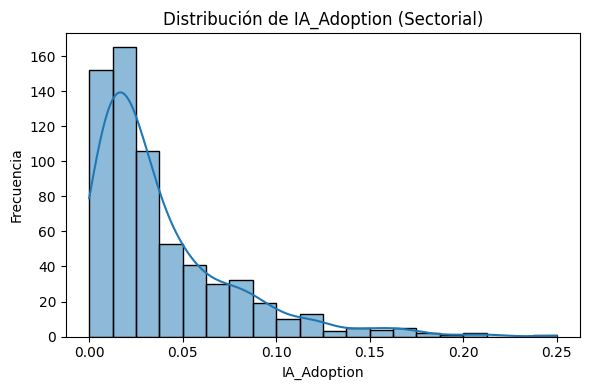

In [62]:
# Histograma de IA_Adoption
plt.figure(figsize=(6,4))
sns.histplot(data_sector['IA_Adoption'], bins=20, kde=True)
plt.title('Distribución de IA_Adoption (Sectorial)')
plt.xlabel('IA_Adoption')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


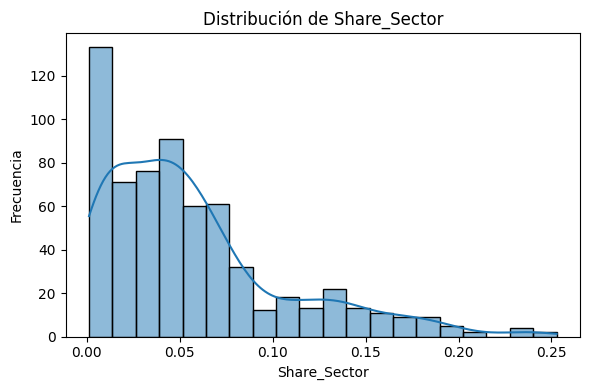

In [63]:
# Histograma de Share_Sector (variable dependiente)
plt.figure(figsize=(6,4))
sns.histplot(data_sector['Share_Sector'], bins=20, kde=True)
plt.title('Distribución de Share_Sector')
plt.xlabel('Share_Sector')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


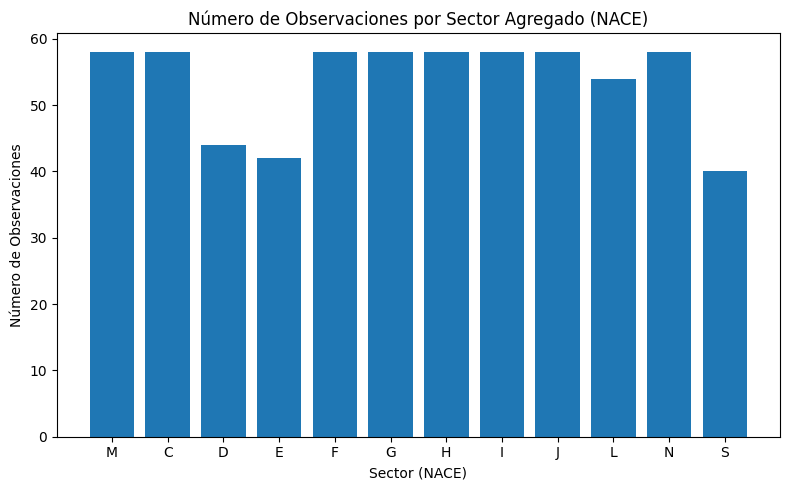

In [64]:
# Observaciones por sector

counts = data_sector['NACE'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(counts.index, counts.values)
ax.set_title('Número de Observaciones por Sector Agregado (NACE)')
ax.set_xlabel('Sector (NACE)')
ax.set_ylabel('Número de Observaciones')
plt.tight_layout()
plt.show()

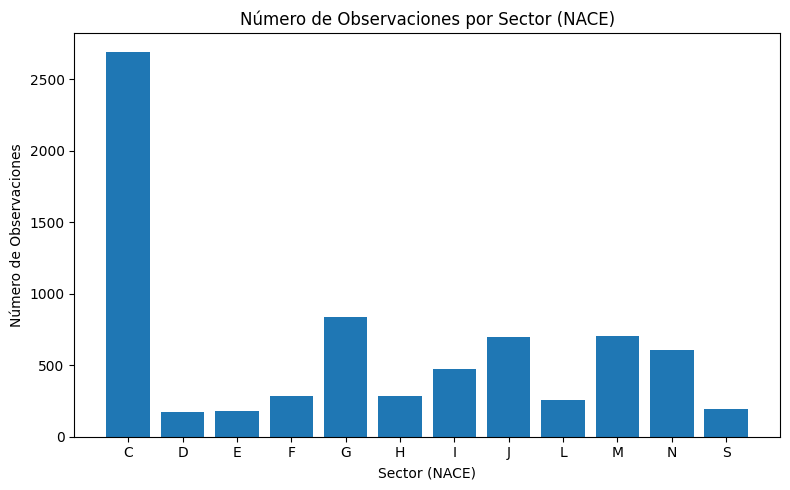

In [65]:
counts = data_IA['NACE'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(counts.index, counts.values)
ax.set_title('Número de Observaciones por Sector (NACE)')
ax.set_xlabel('Sector (NACE)')
ax.set_ylabel('Número de Observaciones')
plt.tight_layout()
plt.show()


/var/folders/jd/z2fjh1_11qq8pyp05ldmsvz00000gn/T/ipykernel_57948/3665288327.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index=['Country', 'NACE'],


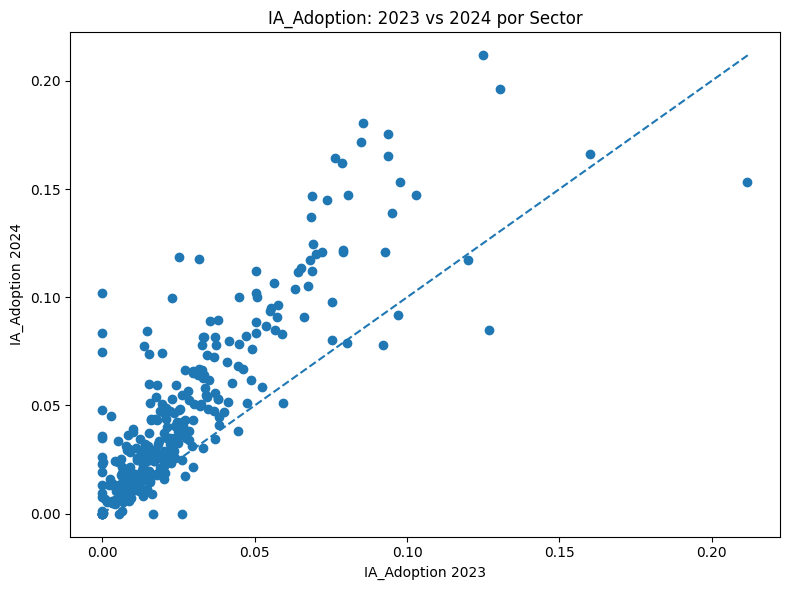

In [66]:
# Crecimiento IA

# 1. Pivot para tener columnas separadas de IA_Adoption en 2023 y 2024
df_wide = (
    data_sector
    .pivot_table(index=['Country', 'NACE'],
                 columns='IdYear',
                 values='IA_Adoption',
                 aggfunc='first')
    .reset_index()
    .rename(columns={23: 'IA_2023', 24: 'IA_2024'})
)

# 2. Eliminar filas con algún NA
df_wide = df_wide.dropna(subset=['IA_2023', 'IA_2024'])

# 3. Gráfica scatter mostrando cada observación
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_wide['IA_2023'], df_wide['IA_2024'])
# Línea 45° para ver crecimiento
lim = max(df_wide['IA_2023'].max(), df_wide['IA_2024'].max())
ax.plot([0, lim], [0, lim], linestyle='--')
ax.set_title('IA_Adoption: 2023 vs 2024 por Sector')
ax.set_xlabel('IA_Adoption 2023')
ax.set_ylabel('IA_Adoption 2024')
plt.tight_layout()
plt.show()


#                          --MODELO 2 - OCUPACIONAL --

In [67]:
# Selecciona las variables clave para el descriptivo
variables_ocup = ['IA_Adoption', 'Share_Occupation', 'GDPCap', 'Educ_Rate', 'Unemp_Rate','Share_Sector']

# Calcula los estadísticos descriptivos básicos (media, desv. estándar, mínimo, máximo)
tabla_descriptiva_ocup = data_occupation[variables_ocup].describe().T[['mean', 'std', 'min', 'max']]
tabla_descriptiva_ocup = tabla_descriptiva_ocup.rename(columns={
    'mean': 'Media',
    'std': 'Desv. Est.',
    'min': 'Mínimo',
    'max': 'Máximo'
})
print(tabla_descriptiva_ocup)

                         Media    Desv. Est.       Mínimo         Máximo
IA_Adoption           0.038135      0.037809     0.000000       0.250000
Share_Occupation      0.100000      0.157704     0.000000       1.000000
GDPCap            33140.590062  20729.081069  8520.000000  101450.000000
Educ_Rate             0.399093      0.084846     0.228817       0.581068
Unemp_Rate            0.057921      0.022131     0.026000       0.122000
Share_Sector          0.056873      0.049362     0.001212       0.252787


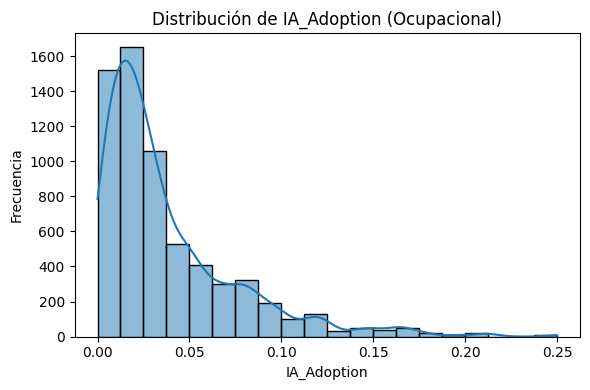

In [68]:
# Histograma de IA_Adoption
plt.figure(figsize=(6,4))
sns.histplot(data_occupation['IA_Adoption'], bins=20, kde=True)
plt.title('Distribución de IA_Adoption (Ocupacional)')
plt.xlabel('IA_Adoption')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

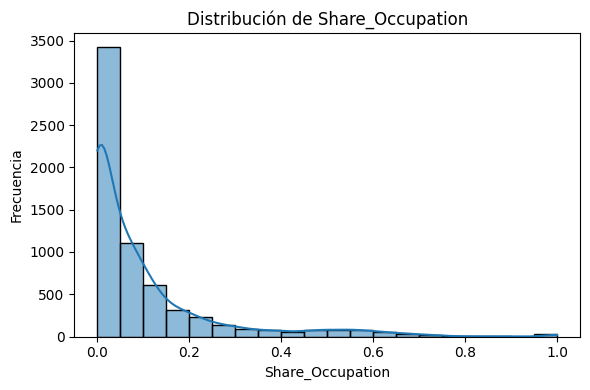

In [69]:
# Histograma de Share_Occupation (variable dependiente)
plt.figure(figsize=(6,4))
sns.histplot(data_occupation['Share_Occupation'], bins=20, kde=True)
plt.title('Distribución de Share_Occupation')
plt.xlabel('Share_Occupation')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [70]:
#Proporciones de ocupaciones

# 1. Agrupa por sector (NACE) y ocupación (ISCO_08), calculando la media de Share_Occupation
df_group = (
    data_occupation
    .groupby(['NACE', 'ISCO_08'], as_index=False)['Share_Occupation']
    .mean()
)

# 2. Pivot a formato ancho: filas = NACE, columnas = OC1…OC9
tabla = (
    df_group
    .pivot(index='NACE', columns='ISCO_08', values='Share_Occupation')
    .fillna(0)
)

# 3. Asegura que las columnas estén en orden OC1…OC9
cols = [f'OC{i}' for i in range(1, 10)]
tabla = tabla.reindex(columns=cols, fill_value=0)

# 4. Añade columna Total que suma las proporciones por fila
tabla['Total'] = tabla.sum(axis=1)

print(tabla.round(2))

/var/folders/jd/z2fjh1_11qq8pyp05ldmsvz00000gn/T/ipykernel_57948/1228239961.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['NACE', 'ISCO_08'], as_index=False)['Share_Occupation']


ISCO_08   OC1   OC2   OC3   OC4   OC5   OC6   OC7   OC8   OC9  Total
NACE                                                                
C        0.06  0.15  0.14  0.07  0.03  0.00  0.28  0.21  0.07    1.0
D        0.03  0.30  0.31  0.11  0.01  0.00  0.21  0.02  0.01    1.0
E        0.02  0.07  0.17  0.09  0.01  0.00  0.10  0.22  0.32    1.0
F        0.06  0.06  0.10  0.04  0.00  0.00  0.56  0.07  0.09    1.0
G        0.08  0.09  0.12  0.09  0.43  0.00  0.10  0.03  0.06    1.0
H        0.05  0.06  0.10  0.19  0.04  0.00  0.03  0.44  0.08    1.0
I        0.09  0.01  0.05  0.06  0.57  0.00  0.01  0.01  0.20    1.0
J        0.08  0.63  0.19  0.06  0.01  0.00  0.02  0.00  0.00    1.0
L        0.08  0.06  0.61  0.10  0.07  0.00  0.02  0.00  0.06    1.0
M        0.07  0.58  0.22  0.09  0.01  0.00  0.02  0.00  0.01    1.0
N        0.05  0.08  0.10  0.13  0.23  0.03  0.03  0.03  0.32    1.0
S        0.04  0.15  0.10  0.05  0.53  0.00  0.06  0.02  0.04    1.0


#                          --MODELO 3 - TEORICO --

In [71]:
# Selecciona las variables clave para el descriptivo
variables = ['IA_Adoption', 'Share_Sector', 'GDPCap', 'Educ_Rate', 'Unemp_Rate','RTI', 'NRA', 'NRI', 'RC', 'RM', 'NRM', 'Mean_RTI']

# Calcula los estadísticos descriptivos básicos (media, desv. estándar, mínimo, máximo)
tabla_descriptiva = data_theory[variables].describe().T[['mean', 'std', 'min', 'max']]
tabla_descriptiva = tabla_descriptiva.rename(columns={
    'mean': 'Media',
    'std': 'Desv. Est.',
    'min': 'Mínimo',
    'max': 'Máximo'
})
print(tabla_descriptiva)

                     Media    Desv. Est.       Mínimo         Máximo
IA_Adoption       0.038135      0.037836     0.000000       0.250000
Share_Sector      0.056873      0.049397     0.001212       0.252787
GDPCap        33140.590062  20743.583129  8520.000000  101450.000000
Educ_Rate         0.399093      0.084905     0.228817       0.581068
Unemp_Rate        0.057921      0.022146     0.026000       0.122000
RTI              -0.422084      0.217866    -0.900000       0.420323
NRA               0.224202      0.141192     0.000000       0.590000
NRI               0.197311      0.077567     0.010000       0.341677
RC                0.193943      0.055721     0.050000       0.395600
RM                0.095239      0.087904     0.000000       0.520000
NRM               0.287664      0.161073     0.020000       0.840000
Mean_RTI         -0.449249      0.212180    -0.891105       0.428919


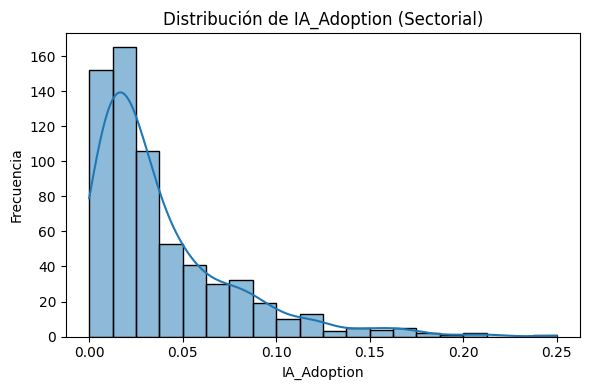

In [72]:
# Histograma de IA_Adoption
plt.figure(figsize=(6,4))
sns.histplot(data_sector['IA_Adoption'], bins=20, kde=True)
plt.title('Distribución de IA_Adoption (Sectorial)')
plt.xlabel('IA_Adoption')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

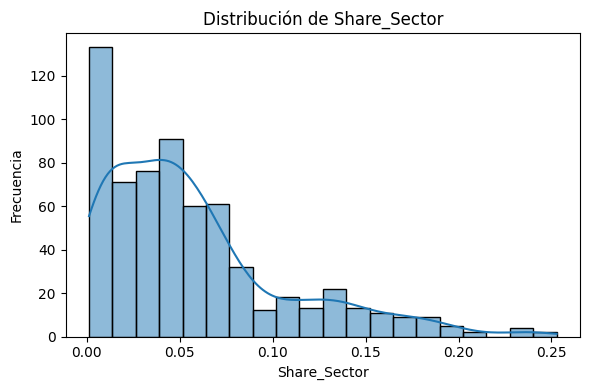

In [73]:
# Histograma de Share_Sector (variable dependiente)
plt.figure(figsize=(6,4))
sns.histplot(data_sector['Share_Sector'], bins=20, kde=True)
plt.title('Distribución de Share_Sector')
plt.xlabel('Share_Sector')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [74]:
# Num observations by country
df_counts = data_sector['Country'].value_counts() \
    .rename_axis('Country') \
    .reset_index(name='Observations')

print(df_counts)

        Country  Observations
0        Sweden            24
1   Netherlands            24
2        Poland            24
3      Portugal            24
4       Belgium            24
5       Romania            24
6       Hungary            24
7        Greece            24
8        France            24
9        Serbia            24
10     Slovakia            24
11      Denmark            24
12      Czechia            24
13     Slovenia            24
14     Bulgaria            24
15      Germany            23
16      Croatia            23
17       Norway            22
18      Austria            22
19       Cyprus            22
20    Lithuania            21
21       Latvia            21
22      Ireland            20
23      Estonia            20
24        Spain            20
25        Malta            18
26      Finland            18
27        Italy            18
28   Luxembourg            16


In [75]:
# Dowload csv:
#data_sector.to_csv('data_sector.csv', index=True)
#data_occupation.to_csv('data_occupation.csv',index=True)
#data_theory.to_csv('data_theory.csv', index=True)